In [14]:
import numpy as np
from keras.datasets import fashion_mnist
import json
def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    # 数据标准化
    x_train = x_train.reshape((-1, 28*28)).astype('float32') / 255.0
    x_test = x_test.reshape((-1, 28*28)).astype('float32') / 255.0
    
    # one-hot编码
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return (x_train, y_train), (x_test, y_test)

In [15]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='relu', regularization=0.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.regularization = regularization
        
        # 权重初始化
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def activate(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Unknown activation function!")

    def activate_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - np.square(x)
        else:
            raise ValueError("Unknown activation function!")

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.activate(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        corect_logprobs = -np.log(y_pred[range(len(y_true)), np.argmax(y_true, axis=1)])
        data_loss = np.sum(corect_logprobs) / len(y_true)
        reg_loss = self.regularization / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return data_loss + reg_loss

    def backward(self, X, y_true, learning_rate):
        m = y_true.shape[0]
        dZ2 = self.A2 - y_true  
        dW2 = np.dot(self.A1.T, dZ2) / m + self.regularization * self.W2
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)  
        dZ1 = dA1 * self.activate_derivative(self.A1)  
        dW1 = np.dot(X.T, dZ1) / m + self.regularization * self.W1
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # 更新权重
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

In [16]:
def test_model(model, x_test, y_test):
    predictions = model.forward(x_test)
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) * 100
    # print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [20]:
class Trainer:
    def __init__(self, model, learning_rate=0.01, epochs=30, batch_size=32):
        self.model = model
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
    def train(self, x_train, y_train, x_val, y_val):
        train_losses = []
        val_losses = []
        val_acces = []
        best_val_loss = float('inf')

        for epoch in range(self.epochs):
            # Shuffle and batch the data
            perm = np.random.permutation(len(x_train))
            x_train_shuffled = x_train[perm]
            y_train_shuffled = y_train[perm]

            # Iterate through mini-batches
            for i in range(0, len(x_train), self.batch_size):
                X_batch = x_train_shuffled[i:i+self.batch_size]
                y_batch = y_train_shuffled[i:i+self.batch_size]
                
                # Forward pass
                y_pred = self.model.forward(X_batch)

                # Compute loss
                loss = self.model.compute_loss(y_batch, y_pred)
                train_losses.append(loss)

                # Backward pass
                self.model.backward(X_batch, y_batch, self.learning_rate)

            # Validate on validation set
            val_pred = self.model.forward(x_val)
            val_loss = self.model.compute_loss(y_val, val_pred)
            val_losses.append(val_loss)
            val_acc = test_model(self.model, x_val, y_val)
            val_acces.append(val_acc)

            print(f"Epoch {epoch + 1}/{self.epochs} - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}, - Val Accuracy: {val_acc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_weights("best.json")

        return train_losses, val_losses, val_acces

    def save_weights(self, filepath):
        # 将权重和偏置保存到文件
        weights = {
            'W1': self.model.W1.tolist(),
            'b1': self.model.b1.tolist(),
            'W2': self.model.W2.tolist(),
            'b2': self.model.b2.tolist(),
        }
        with open(filepath, 'w') as f:
            json.dump(weights, f)

    def load_best_weights(self, filepath):
        # 从文件加载权重和偏置
        with open(filepath, 'r') as f:
            weights = json.load(f)
        self.model.W1 = np.array(weights['W1'])
        self.model.b1 = np.array(weights['b1'])
        self.model.W2 = np.array(weights['W2'])
        self.model.b2 = np.array(weights['b2'])

Epoch 1/30 - Train Loss: 1.0709 - Val Loss: 1.1229, - Val Accuracy: 63.8167
Epoch 2/30 - Train Loss: 0.8530 - Val Loss: 0.8967, - Val Accuracy: 70.9333
Epoch 3/30 - Train Loss: 0.8976 - Val Loss: 0.8195, - Val Accuracy: 75.7250
Epoch 4/30 - Train Loss: 0.7471 - Val Loss: 0.7697, - Val Accuracy: 77.7917
Epoch 5/30 - Train Loss: 0.7010 - Val Loss: 0.7395, - Val Accuracy: 79.3667
Epoch 6/30 - Train Loss: 0.7802 - Val Loss: 0.7203, - Val Accuracy: 80.5167
Epoch 7/30 - Train Loss: 0.7810 - Val Loss: 0.7022, - Val Accuracy: 81.6583
Epoch 8/30 - Train Loss: 0.5480 - Val Loss: 0.6926, - Val Accuracy: 81.9917
Epoch 9/30 - Train Loss: 0.6988 - Val Loss: 0.6873, - Val Accuracy: 82.1833
Epoch 10/30 - Train Loss: 0.7274 - Val Loss: 0.6753, - Val Accuracy: 82.6667
Epoch 11/30 - Train Loss: 0.6257 - Val Loss: 0.6713, - Val Accuracy: 82.9333
Epoch 12/30 - Train Loss: 0.6502 - Val Loss: 0.6686, - Val Accuracy: 82.7750
Epoch 13/30 - Train Loss: 0.7639 - Val Loss: 0.6623, - Val Accuracy: 83.0333
Epoch 14

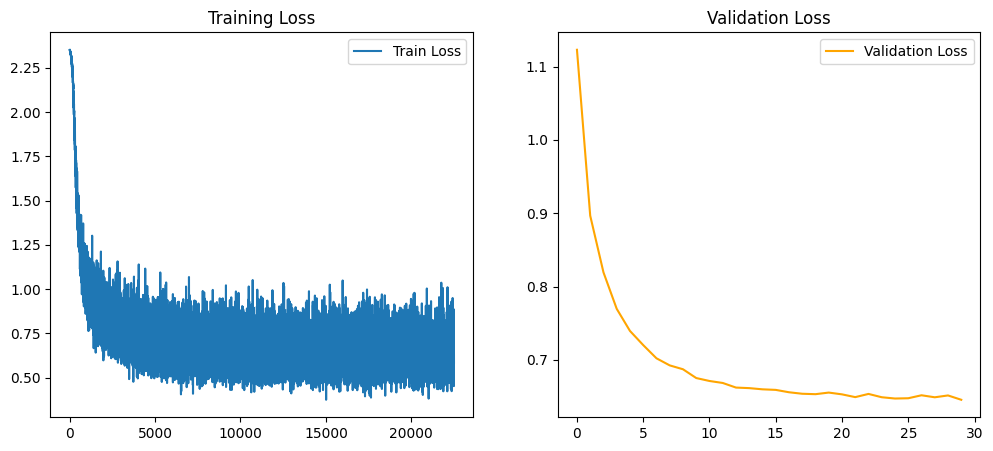

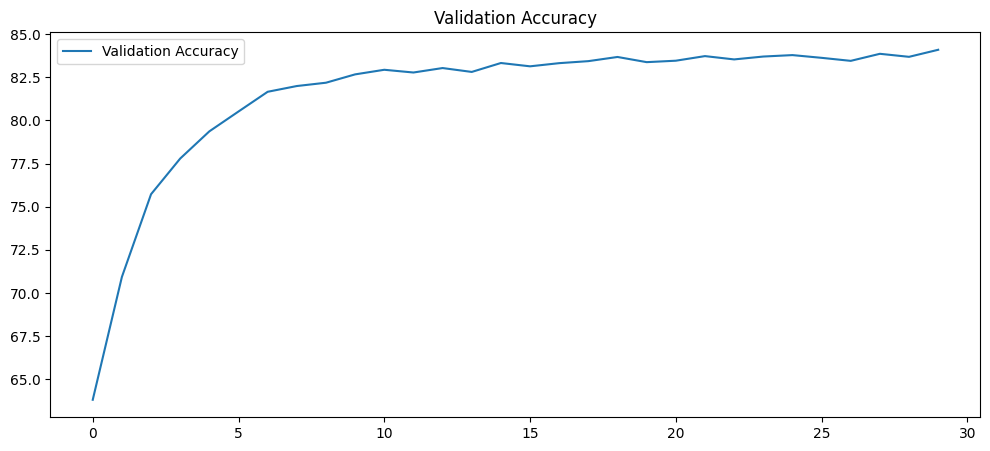

In [22]:
if __name__ == "__main__":
    # 加载数据集
    (x_train, y_train), (x_test, y_test) = load_data()
    
    # 划分数据集
    validation_split_index = int(0.8 * len(x_train))
    x_val = x_train[validation_split_index:]
    y_val = y_train[validation_split_index:]
    x_train = x_train[:validation_split_index]
    y_train = y_train[:validation_split_index]

    # 超参配置
    input_size = 28 * 28 
    hidden_size = 128 
    output_size = 10 

    model = NeuralNetwork(input_size, hidden_size, output_size, activation='relu', regularization=0.01)
    trainer = Trainer(model, learning_rate=0.01, epochs=30, batch_size=64)
    train_losses, val_losses, val_acces = trainer.train(x_train, y_train, x_val, y_val)

    # Load the best model weights and test it
    trainer.load_best_weights("best.json")
    tett_acc = test_model(model, x_test, y_test)
    print(f"Test Accuracy: {tett_acc:.2f}%")

    # Plotting (loss curves) for illustration, would normally use matplotlib
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Training Loss")
    plt.plot(train_losses, label="Train Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Validation Loss")
    plt.plot(val_losses, label="Validation Loss", color='orange')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 5))
    plt.title("Validation Accuracy")
    plt.plot(val_acces, label="Validation Accuracy")
    plt.legend()
    plt.show()